# KernelBench: Tutorial [NeurIPS '25 Tutorial]


In this tutorial we will walk through the basics of KernelBench and let you try an example!
You can even do this in a Google Colab on T4 GPU.

**ACTION: Make a copy of this Google Colab**

We will use the open-source repo of [KernelBench](https://github.com/ScalingIntelligence/KernelBench) from Stanford's [Scaling Intelligence Lab](https://scalingintelligence.stanford.edu/).

Made by Simon Guo, William Hu, Omar Abul-Hassan. Last updated Dec '25.

Run this on Google Colab or your local machine with GPU.

Contact: {simonguo, willhu}@stanford.edu

### Set up
KernelBench needs to run on GPU (as we need to evaluate GPU kernels).

We first check our runtime to confirm that we have a GPU.

In [ ]:
!nvidia-smi

Next, let's set up KernelBench 🍿

In [ ]:
!git clone https://github.com/ScalingIntelligence/KernelBench.git

In [ ]:
%cd /content/KernelBench

Download dependencies! Ignore if you are running this locally, only follow those if you are on Colab.

In [ ]:
# Latest KernelBench uses PyTorch 2.9.0 (latest version that supports Blackwell)
# !pip install -r requirements.txt

# However, for this exercise, we will use the latest pytorch that ship with Google colab
import torch
torch.__version__

In [ ]:
# here is a min set of our requirements
!pip install pydra_config
!pip install modal
!pip install litellm
!pip install ninja
!pip install tomli

In [ ]:
# install repo package
!pip install -e .

In [ ]:
import os
# temporary directory for storing kernels
directory = "tmp"
if not os.path.exists(directory):
  os.makedirs(directory)

## KernelBench Task Format

KernelBench is a benchmark and environment for evaluating LLM's ability to generate efficient GPU kernels. You can read more from our [paper](https://arxiv.org/abs/2502.10517).


Concretely, KernelBench tasks LMs with generating optimized CUDA kernels for a given target PyTorch model architecture and conducts automated evaluation

* Input: `Model` as PyTorch reference
* Output: `ModelNew` of PyTorch + inline CUDA kernel.

The model has freedom to choose which part of the input PyTorch ops it would optimize and generate CUDA kernels.

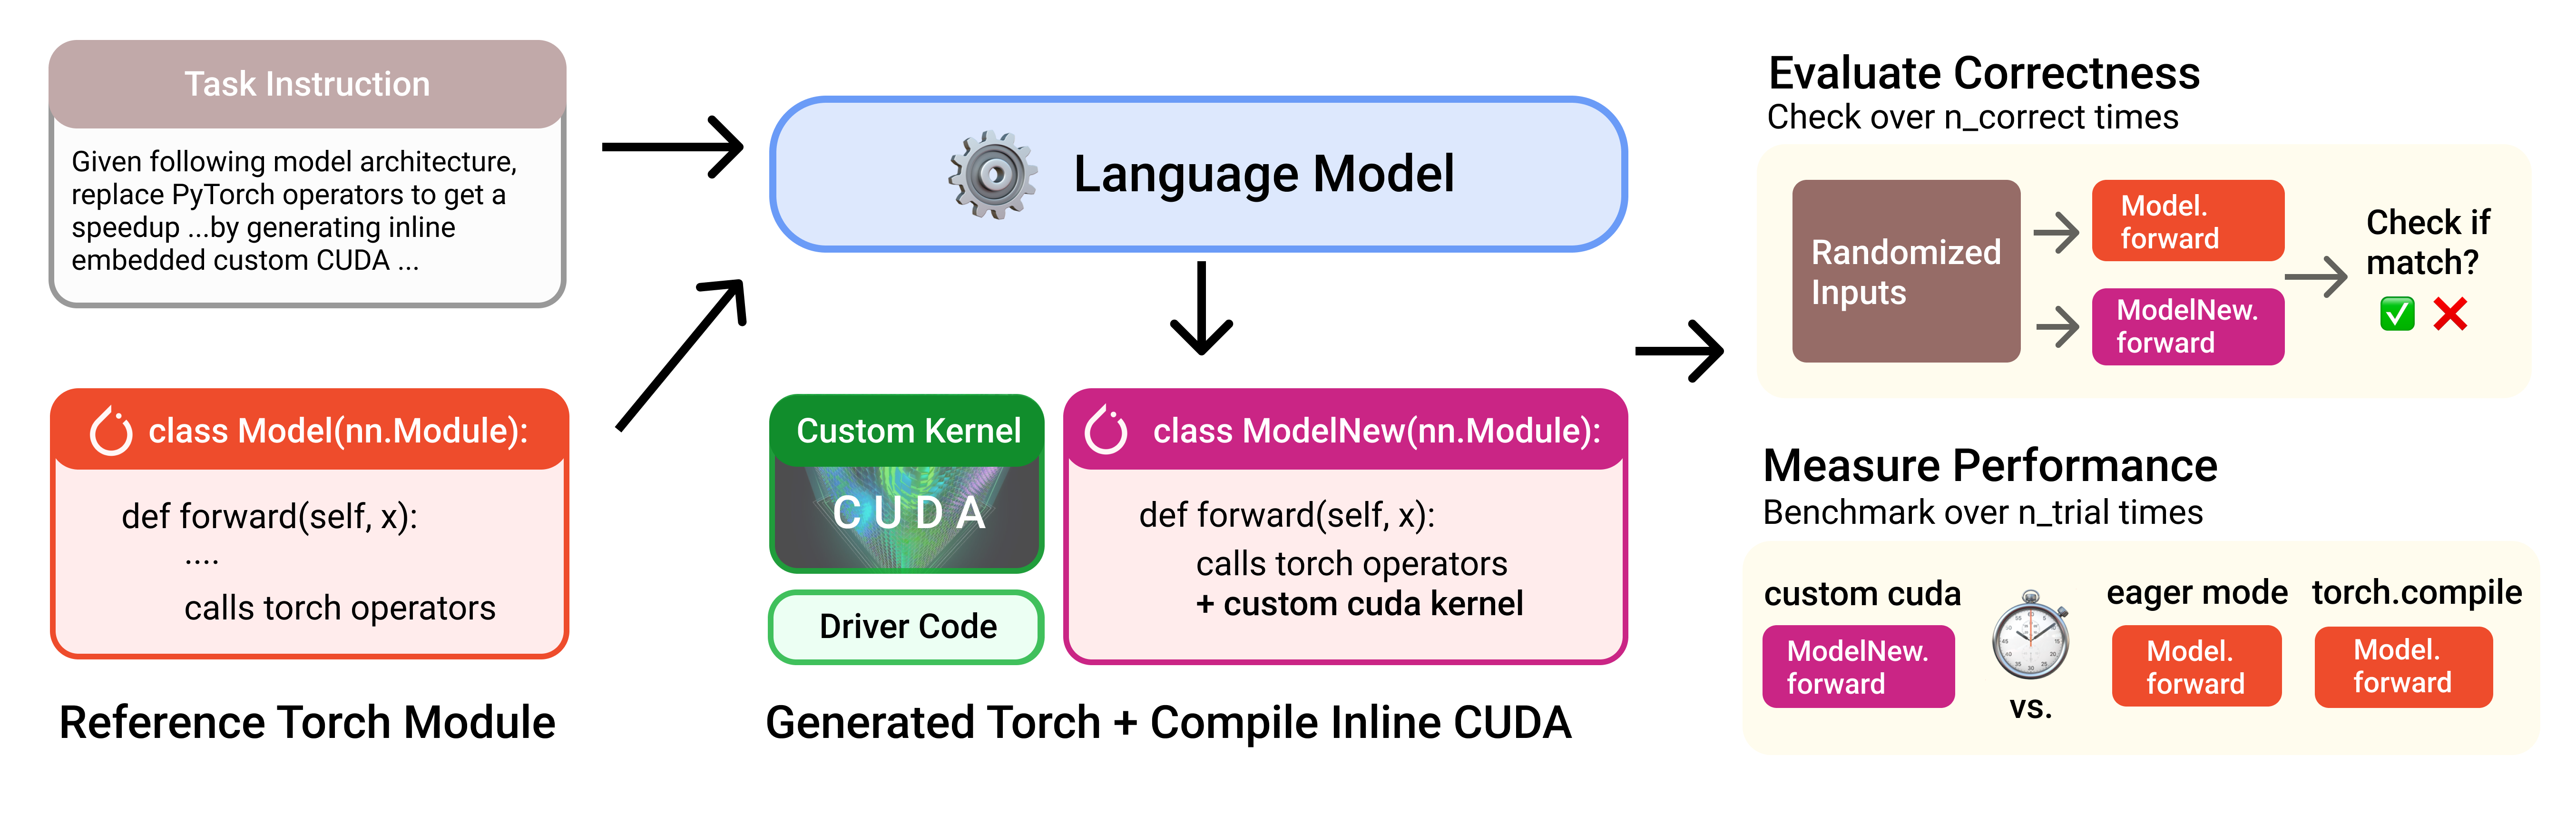

As a minimum example, we show the case for **Element-wise Addition**.

KernelBench relies on comparing two implementations:
1.  **Reference (`Model`):** The ground-truth PyTorch code.
2.  **Generation (`ModelNew`):** The LLM-generated code containing an inline C++/CUDA kernel.

Here we save them to locally to demonstrate a minimum evaluation flow.

First, we show the PyTorch reference for element-wise addition.

In [ ]:
ex_add_model_ref = '''
import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, a, b):
        return a + b


def get_inputs():
    # randomly generate input tensors based on the model architecture
    a = torch.randn(1, 128).cuda()
    b = torch.randn(1, 128).cuda()
    return [a, b]


def get_init_inputs():
    # randomly generate tensors required for initialization based on the model architecture
    return []
'''


with open("tmp/ex_add_model_ref.py", "w") as f:
  f.write(ex_add_model_ref)

Here, we have a PyTorch module `ModelNew` with **inline `cuda` kernel**. This would be typically be the AI-generated kernel.

In [ ]:
ex_add_model_generation = '''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.cpp_extension import load_inline

# Define the custom CUDA kernel for element-wise addition
elementwise_add_source = """
#include <torch/extension.h>
#include <cuda_runtime.h>

__global__ void elementwise_add_kernel(const float* a, const float* b, float* out, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size) {
        out[idx] = a[idx] + b[idx];
    }
}

torch::Tensor elementwise_add_cuda(torch::Tensor a, torch::Tensor b) {
    auto size = a.numel();
    auto out = torch::zeros_like(a);

    const int block_size = 256;
    const int num_blocks = (size + block_size - 1) / block_size;

    elementwise_add_kernel<<<num_blocks, block_size>>>(a.data_ptr<float>(), b.data_ptr<float>(), out.data_ptr<float>(), size);

    return out;
}
"""

elementwise_add_cpp_source = (
    "torch::Tensor elementwise_add_cuda(torch::Tensor a, torch::Tensor b);"
)

# Compile the inline CUDA code for element-wise addition
elementwise_add = load_inline(
    name="elementwise_add",
    cpp_sources=elementwise_add_cpp_source,
    cuda_sources=elementwise_add_source,
    functions=["elementwise_add_cuda"],
    verbose=True,
    extra_cflags=[""],
    extra_ldflags=[""],
)


class ModelNew(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.elementwise_add = elementwise_add

    def forward(self, a, b):
        return self.elementwise_add.elementwise_add_cuda(a, b)
'''

with open("tmp/ex_add_model_generation.py", "w") as f:
  f.write(ex_add_model_generation)

Run `run_and_check.py`\ with the generation (with inline cuda, here `ex_add_model_generation`) against refernece (pure PyTorch, here `ex_add_model_ref`)

In [ ]:
!python3 scripts/run_and_check.py ref_origin=local gpu_arch="['Turing']"  ref_arch_src_path=tmp/ex_add_model_ref.py kernel_src_path=tmp/ex_add_model_generation.py

Note PyTorch `torch.compile` has some runtime (beyond compile!) overhead. Note it also has many modes for compilation, while performance varies based on hardware SM generation and PyTorch version.

For Level 1, we recommend compare against Torch Eager.
For Level 2/3, we recommend compare against `torch.compile`.

# Evaluating a generated KernelBench kernel example

We designed KernelBench with 3 levels (total 250 tasks), each challenging in a distinct way:


* **Level 1 Single Operators** (100): e.g., matmul, conv; this is actually quite hard since we would be competing against highly-optimized libraries
* **Level 2 Sequence of Operators** (100): help test model’s ability to conduct kernel fusion, a key technique used by graph compilers
* **Level 3 End-to-end architectures** (50): like a Vision Transformer or Mamba block, evaluate model’s ability to identify optimization opportunities within whole model architecture


In [ ]:
# @title Select KernelBench Problem Configuration 🎛️
# @markdown Select the difficulty level (1-3) and specific problem ID.
# @markdown * **Level 1 & 2:** 100 Problems
# @markdown * **Level 3:** 50 Problems

level = 1 # @param {type:"slider", min:1, max:3, step:1}
problem_id = 1 # @param {type:"slider", min:1, max:100, step:1}

# Input Validation Logic
max_problems = 50 if level == 3 else 100

if problem_id > max_problems:
    print(f"⚠️ Warning: Level {level} only has {max_problems} problems.")
    print(f"   -> Automatically adjusting Problem ID from {problem_id} to {max_problems}.")
    problem_id = max_problems

print(f"Selected: Level {level}, Problem ID {problem_id}")

In [ ]:
from datasets import load_dataset
import os

# Load the dataset based on the sliders above
dataset = load_dataset("ScalingIntelligence/KernelBench")
level_string = "level_" + f"{level}"

try:
    # Fetch the problem
    target_kernel_reference = dataset[level_string][problem_id]["code"]
    problem_name = dataset[level_string][problem_id]["name"]

    print(f"✅ Successfully loaded: {problem_name}")
    print("="*80)
    print(target_kernel_reference)

    # Save to file for the next steps
    with open("tmp/reference.py", "w") as f:
      f.write(target_kernel_reference)

except IndexError:
    print(f"❌ Error: Problem ID {problem_id} does not exist in Level {level}. Please adjust the slider to a lower number.")

In [ ]:
target_kernel_reference = dataset[level_string][problem_id]["code"]
print(target_kernel_reference)

with open("tmp/reference.py", "w") as f:
  f.write(target_kernel_reference)


Now we construct the context to condition the LM for generation.

The context consists of:
1.  **PyTorch Source:** We take the reference PyTorch code of the KernelBench problem.
2.  **Few-Shot Examples [Optional]:** We include a few examples of hand-written pairs of `Model`, `ModelNew`. By default, we use the pair of element-wise add example to show model the correct syntax and class structure, (aka how to use   `torch.utils.cpp_extension.load_inline`).
3.  **Hardware Context [Optional]:** We inject specific GPU specs (e.g., **SRAM size, memory bandwidth**) into the prompt. This allows the LLM to potentially calculate adjust tile sizes (e.g., `BLOCK_SIZE`) for your specific hardware (T4 vs A100).
4. **Backend & Precision**: You can specify which backend (`cuda` or other DSLs) and numerical percision.

Of course you can also customize your prompt, or plug in your favorite agentic systems. For this tutorial, you will **copy** (or modify) the generated prompt below, send it to your favorite model / coding agent, and **paste** the result back!

In [ ]:
from kernelbench.prompt_constructor_toml import get_prompt_for_backend

# Here is an example of a constructed context with hardware context
# This injects specs (memory bandwidth, cache size) from kernelbench/prompts/hardware/gpu_specs.py
# helping the LLM optimize tile sizes for your specific GPU.

prompt = get_prompt_for_backend(
    ref_arch_src=target_kernel_reference,
    backend="cuda",   # You can also try "triton" or "tilelang" here!
    option="one_shot", # <--- show example of generation format via minimum example
    include_hardware=True, # <--- Enable hardware specific context
    gpu_name="T4"          # <--- Specify your GPU (matches keys in gpu_specs.py)
)

print("="*40)
print("  ⬇️ COPY THIS PROMPT TO YOUR LLM ⬇️  ")
print("="*40)
print(prompt)
print("="*40)

In [ ]:
target_kernel_generation = "paste the output here"

For this tutorial, we have pre-generated a solution for the Matrix Multiplication problem (level=1, problem=1) using a standard LLM.

**Note:** The kernel below is a naive CUDA implementation. While functionally correct, it's *slower* than PyTorch (which uses highly optimized cuBLAS). This is expected in Level 1. The challenge is to prompt the LLM to write tiled/shared-memory implementations to beat cuBLAS.

In [ ]:
# Here is an example model-generated kernel if you chose to optimize Level 1 Problem 1

# By the way, this is a very slow and naive implementation in cuda; lots of room for improvement, try how you can beat this with your own generation!

level_1_problem_1_sample_0_kernel = '''import torch
import torch.nn as nn
from torch.utils.cpp_extension import load_inline

# Define the custom CUDA kernel for matrix multiplication
matrix_multiply_source = """
#include <torch/extension.h>
#include <cuda_runtime.h>

__global__ void matrix_multiply_kernel(const float* A, const float* B, float* C, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int i = 0; i < N; i++) {
            sum += A[row * N + i] * B[i * N + col];
        }
        C[row * N + col] = sum;
    }
}

torch::Tensor matrix_multiply_cuda(torch::Tensor A, torch::Tensor B) {
    auto N = A.size(0);
    auto C = torch::zeros_like(A);

    const int block_size = 16;
    const int num_blocks_x = (N + block_size - 1) / block_size;
    const int num_blocks_y = (N + block_size - 1) / block_size;

    dim3 block(block_size, block_size);
    dim3 grid(num_blocks_x, num_blocks_y);

    matrix_multiply_kernel<<<grid, block>>>(A.data_ptr<float>(), B.data_ptr<float>(), C.data_ptr<float>(), N);

    return C;
}
"""

matrix_multiply_cpp_source = (
    "torch::Tensor matrix_multiply_cuda(torch::Tensor A, torch::Tensor B);"
)

# Compile the inline CUDA code for matrix multiplication
matrix_multiply = load_inline(
    name="matrix_multiply",
    cpp_sources=matrix_multiply_cpp_source,
    cuda_sources=matrix_multiply_source,
    functions=["matrix_multiply_cuda"],
    verbose=True,
    extra_cflags=[""],
    extra_ldflags=[""],
)


class ModelNew(nn.Module):
    def __init__(self):
        super(ModelNew, self).__init__()
        self.matrix_multiply = matrix_multiply

    def forward(self, A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
        return self.matrix_multiply.matrix_multiply_cuda(A, B)
'''

# uncomment if you want to use this example
target_kernel_generation = level_1_problem_1_sample_0_kernel

In [ ]:
with open("tmp/generation.py", "w") as f:
  f.write(target_kernel_generation)

## Check your Generated Kernel Performance


Note some of the KernelBench problem sizes are quite big! This is too ensure [CPU overhead](https://scalingintelligence.stanford.edu/blogs/kernelbenchv01/) is not too significant. As our tensor sizes are calibrated on NVIDIA H100, you might run into OOM on a small GPU for some problems; reduce the problem sizes for those!

Adjust `precision`, `num_trials`, `backend` etc as needed!

In [ ]:
!python scripts/run_and_check.py ref_origin=kernelbench gpu_arch="['Turing']" level={level} problem_id={problem_id} kernel_src_path=tmp/generation.py

When you run the command above, look for these lines in the logs for evaluation result:

1.  **`[Eval] Correctness: True/False`**:
    *   This runs the kernel against the reference with random inputs with `num_correct_trials`.
    *   For **FP32**, we enforce `atol=1e-4`. Following PyTorch guideline, we have different tolerance for various precisions.
    *   If this fails, the kernel is functionally invalid, and speedup metrics are ignored.

2.  **`[Speedup] Speedup over eager: X.XXx`**:
    * For Speedup we run both the reference and generated kernel `num_trials` time (100 typically), and compute speedup!
    *   `< 1.0x`: The generated kernel is slower than PyTorch (common for naive implementations).
    *   `> 1.0x`: The generated kernel is faster.

3.  **`[Speedup] Speedup over torch.compile: Y.YYx`**:
    *   This compares against `torch.compile(mode="inductor")`. This is the harder boss to beat for Level 2/3 problems involving kernel fusions!

## Next Steps

Congrats on finishing this tutorial! We show the minimum usage of KernelBench. Beyond acting as a benchmark, KernelBench tasks also serve as an environment to develop many techniques to tackle AI-generating GPU kernels. We have noted down many of the developments we are aware [here](https://docs.google.com/document/d/e/2PACX-1vTjS-UMH1HB5n_PENq2k-3YRfXIXkqKIKeNC2zcWMyLPdl4Jrwvdk4dNDVSsM8ybKrCxZB7GJq1slZF/pub), from building agentic systems to applying reinforcement learning.

As a pro tip, you should be always **careful about speedup numbers**; kernel engineers and existing compilers are already pretty good, so a >2x speedup for anything is highly unlikely. While we are constantly improving our eval to be more robust and comprehensive, you should always **read the generated kernel in detail** to avoid reward hacking!  

As a KernelBench is an open-soruce project, you are welcome to contribute to our [Github](https://github.com/ScalingIntelligence/KernelBench) to add new features or make it better!

Have fun playing with KernelBench! Can't wait to see what you find out!
